# **5. Validación**

Un modelo ARIMA debe ser lo más adecuado posible para representar el comportamiento de la serie. Se debe probar que cumpla lo siguiente:
1. Los coeficientes del modelo son estadı́sticamente significativos y no
están correlacionados entre sı́.
2. Los residuos del modelo estimado se aproximan al comportamiento de
un ruido blanco.
3. El grado de ajuste es elevado en comparación al de otros modelos al-
ternativos.
4. El modelo es estacionario e invertible.

##  Estadísticamente significativos

El test de significatividad  tiene un objetivo claro: **determinar si los términos que has incluido en el modelo  realmente aportan información valiosa para predecir el futuro o si son simplemente ruido.**

Para esto, se utiliza el **estadístico t (t-statistic)** individual para cada coeficiente estimado. A

### 1. El planteamiento de las hipótesis

Para cada coeficiente en tu modelo (llamémoslo $\beta$, que puede ser un término autorregresivo $\phi$ o de media móvil $\theta$), realizamos una prueba de hipótesis individual:

* **Hipótesis Nula ($H_0$):** $\beta = 0$.
    * *Significado:* El coeficiente es igual a cero. La variable no tiene efecto en el modelo y no ayuda a predecir. Debería eliminarse.
* **Hipótesis Alternativa ($H_1$):** $\beta \neq 0$.
    * *Significado:* El coeficiente es significativamente diferente de cero. La variable aporta información y debe mantenerse en el modelo.

### 2. El cálculo del estadístico t


$$t = \frac{\hat{\beta}}{SE(\hat{\beta})}$$

Donde:
* $\hat{\beta}$: Es el valor estimado del coeficiente (ej. 0.75).
* $SE(\hat{\beta})$: Es el Error Estándar* de esa estimación (una medida de cuánto podría variar este estimado).

 Si el coeficiente es grande en comparación con su error (ruido), el valor $t$ será grande (positivo o negativo), lo que sugiere que el efecto es real.

### 3. La decisión: El Valor P (P-value)

El estadístico $t$ se traduce en un P-value. Esta es la métrica que usarás para tomar la decisión rápida. Usualmente trabajamos con un nivel de confianza del 95% ($\alpha = 0.05$).

* **Si $P\text{-value} < 0.05$:**
    * Rechazamos la hipótesis nula ($H_0$).
    * Conclusión: El coeficiente es **estadísticamente significativo**.

* **Si $P\text{-value} > 0.05$:**
    * No podemos rechazar la hipótesis nula.
    * Conclusión: No hay evidencia suficiente para decir que el coeficiente es diferente de cero.


In [2]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import pandas as pd
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats
serie = pd.read_csv('train.csv')['Monthly Mean Total Sunspot Number']
val = pd.read_csv('valid.csv')['Monthly Mean Total Sunspot Number']

In [3]:
model = ARIMA(serie, order=(4, 0, 0))
model_fit = model.fit()
alfa = 0.05

In [4]:
params = model_fit.params

cov_matrix = model_fit.cov_params()

bse_manual = np.sqrt(np.diag(cov_matrix))

t_values = params / bse_manual

p_values = (1 - stats.norm.cdf(np.abs(t_values))) * 2

significativos = p_values < alfa

resultados = pd.DataFrame({
    'Coeficiente': params,
    'Std. Error ': bse_manual,
    't ': t_values,
    'P-value ': p_values,
    'significativo': significativos
})

print(resultados)

        Coeficiente  Std. Error          t       P-value   significativo
const     84.111984    14.078496   5.974501  2.307961e-09           True
ar.L1      0.585699     0.014315  40.914766  0.000000e+00           True
ar.L2      0.133374     0.016134   8.266472  2.220446e-16           True
ar.L3      0.097548     0.016990   5.741350  9.392460e-09           True
ar.L4      0.140397     0.014496   9.685309  0.000000e+00           True
sigma2   661.752416    11.118050  59.520546  0.000000e+00           True



### Validación de residuos
El correlograma de errores debe evidenciar ausencia de autocorrelación significativa (ruido blanco) mediante barras que permanezcan dentro de las bandas de confianza, indicando que toda la estructura temporal ha sido capturada. Complementariamente, se debe verificar que estos residuos sigan una distribución normal para asegurar que los intervalos de confianza de las predicciones sean válidos; para ello se utiliza la prueba de Jarque-Bera, la cual evalúa la asimetría y curtosis de la distribución de errores, donde un resultado que no rechace la hipótesis nula (p>0.05) confirma que los residuos se comportan gaussianamente y legitima las inferencias estadísticas del modelo.

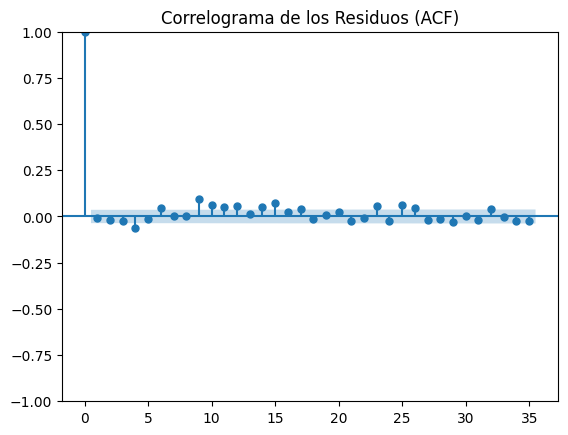

In [5]:
residuos = model_fit.resid
plot_acf(residuos, title="Correlograma de los Residuos (ACF)")
plt.show()

In [6]:
stats.jarque_bera(residuos)

SignificanceResult(statistic=np.float64(1569.3002868020205), pvalue=np.float64(0.0))

In [7]:


jb_value, p_value = stats.jarque_bera(residuos)

print(f"Valor JB calculado: {jb_value:.4f}")
print(f"P-value: {p_value:.4f}")

limite_chi2 = 5.991

print("\n--- DECISIÓN ---")
if jb_value > limite_chi2:
    print(f"Resultado: {jb_value:.4f} > {limite_chi2}")
    print("RECHAZAMOS H0. Los residuos NO siguen una distribución normal.")
else:
    print(f"Resultado: {jb_value:.4f} <= {limite_chi2}")
    print("NO RECHAZAMOS H0. Los residuos parecen normales.")


Valor JB calculado: 1569.3003
P-value: 0.0000

--- DECISIÓN ---
Resultado: 1569.3003 > 5.991
RECHAZAMOS H0. Los residuos NO siguen una distribución normal.


(array([   3.,   35.,  213., 1171., 1129.,  289.,   78.,   13.,    2.,
           5.]),
 array([-114.13493089,  -86.32361713,  -58.51230336,  -30.70098959,
          -2.88967582,   24.92163795,   52.73295172,   80.54426548,
         108.35557925,  136.16689302,  163.97820679]),
 <BarContainer object of 10 artists>)

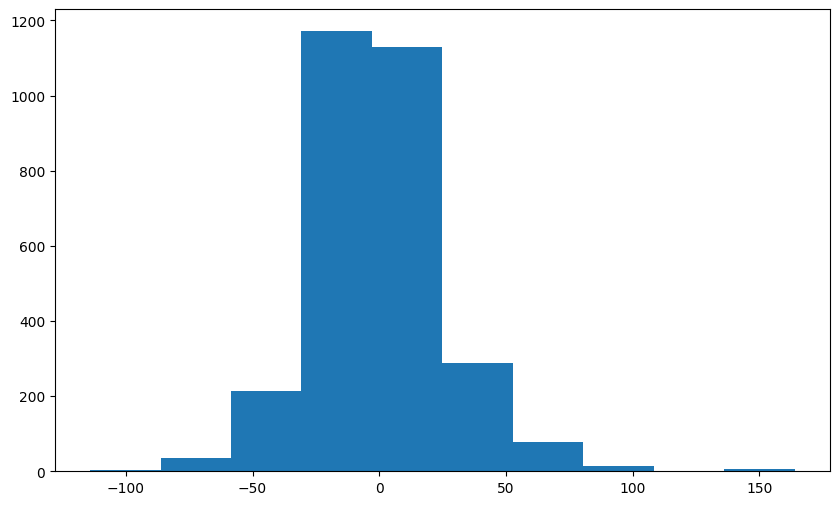

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(residuos, label='Residuos')

## Estacionariedad e Invertibilidad

Tanto la parte Autorregresiva (AR) como la de Medias Móviles (MA) se pueden representar como polinomios. Para validar el modelo, analizamos las **raíces** (soluciones) de estos polinomios característicos en el plano complejo.

  * **Estacionariedad (Componente AR):** Garantiza que la media y la varianza del proceso no crezcan indefinidamente.
      * Matemáticamente: Las raíces del polinomio AR ($\phi(z) = 0$) deben caer **fuera** del círculo unitario (módulo $> 1$).
  * **Invertibilidad (Componente MA):** Garantiza que el modelo tenga sentido presente en función del pasado (que los pesos de las observaciones pasadas decaigan).
      * Matemáticamente: Las raíces del polinomio MA ($\theta(z) = 0$) deben caer **fuera** del círculo unitario.

### La Prueba Gráfica

Dado que visualizar números grandes en el plano complejo es incómodo, al invertir las raíces ($1/\text{raíz}$), la condición de estabilidad se invierte: ahora se busca que los puntos caigan dentro del círculo de radio 1.

* Si los puntos rojos (AR) están dentro: El modelo es **Estacionario**.
* Si los puntos azules (MA) están dentro: El modelo es **Invertible**.
* Si un punto cae exactamente sobre la línea negra (radio = 1), hay una raíz unitaria.

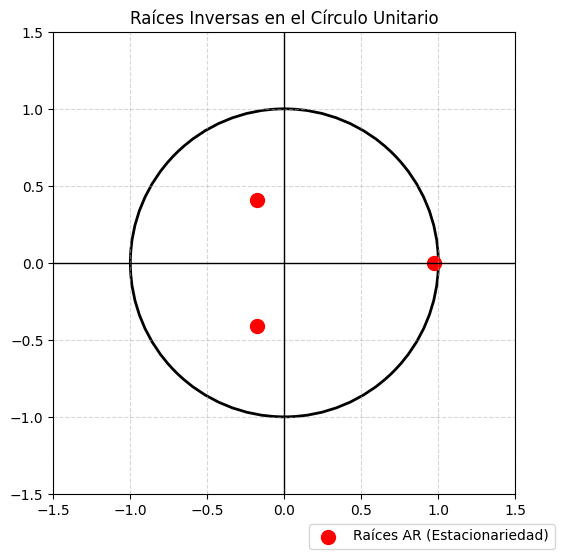

In [33]:

ar_roots = model_fit.arroots
ma_roots = model_fit.maroots

inv_ar_roots = 1 / ar_roots if len(ar_roots) > 0 else []
inv_ma_roots = 1 / ma_roots if len(ma_roots) > 0 else []


fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.grid(True, which='both', linestyle='--', alpha=0.5)
ax.axhline(y=0, color='k', linewidth=1)
ax.axvline(x=0, color='k', linewidth=1)


circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=2, linestyle='-')
ax.add_artist(circle)


if len(inv_ar_roots) > 0:
    plt.scatter(np.real(inv_ar_roots), np.imag(inv_ar_roots),
                s=100, c='red', marker='o', label='Raíces AR (Estacionariedad)')

if len(inv_ma_roots) > 0:
    plt.scatter(np.real(inv_ma_roots), np.imag(inv_ma_roots),
                s=100, c='blue', marker='x', label='Raíces MA (Invertibilidad)')

plt.legend(bbox_to_anchor=(1.1, -0.05))
plt.title('Raíces Inversas en el Círculo Unitario')
plt.show()

Los puntos rojos (AR) están dentro: El modelo es Estacionario. En este caso no hay raíces (MA)

# Predicción

Mediante la función de
predicción podemos elaborar estimaciones del comportamiento de la serie en
el futuro.
Después de haber obtenido los valores de predicción es necesario conocer
cuál es la magnitud del error que se ha cometido, el cual es denominado error
de predicción, que se define como la diferencia entre la realización de la serie
y la predicción de la misma.


### Pronóstico
El pronóstico puntual para un horizonte de tiempo $h$ (donde $h \geq 1$), denotado como $\hat{Y}_{T+h|T}$, se define matemáticamente como la **esperanza condicional** de la variable $Y_{T+h}$ dada la información disponible hasta el momento $T$ ($\mathcal{I}_T$).

$$\hat{Y}_{T+h|T} = E[Y_{T+h} | \mathcal{I}_T]$$

Donde $\mathcal{I}_T$ incluye todos los valores observados ($y_1, \dots, y_T$) y los residuos estimados ($\hat{\epsilon}_1, \dots, \hat{\epsilon}_T$).



El cálculo se ejecuta mediante un proceso iterativo conocido como **"Bootstrap" o Sustitución Recursiva**, que sigue tres reglas fundamentales:

#### 1. Tratamiento del Componente Autoregresivo (AR)
Para los términos AR, el modelo utiliza los valores pasados de la serie.
* Si el rezago cae en el **pasado** ($t+h-p \leq T$), se utiliza el dato observado real ($y_t$).
* Si el rezago cae en el **futuro** ($t+h-p > T$), se sustituye el valor desconocido por su **predicción previa** ($\hat{y}_t$).

#### 2. Tratamiento del Componente de Media Móvil (MA)
Para los términos MA, el modelo utiliza los errores de pronóstico (innovaciones).
* Si el rezago corresponde al **pasado** (dentro de la muestra), se utiliza el residuo estimado ($\hat{\epsilon}_t$).
* Si el rezago corresponde al **futuro** ($t+h > T$), el valor esperado del error es **cero** ($E[\epsilon_{t+h}] = 0$), dado que se asume que las innovaciones futuras son ruido blanco no correlacionado. Por tanto, **el término MA se anula para predicciones lejanas.**

#### 3. Integración (Reconstrucción de Nivel)
Si el modelo incluye diferenciación ($d \geq 1$), la ecuación anterior predice la serie diferenciada ($\hat{\Delta}^d Y_t$). Para obtener el pronóstico en la escala original, se debe realizar una **suma acumulativa (integración)** de las predicciones sobre el último valor observado $Y_T$.

Para un paso $h$ en el futuro:

$$\hat{Y}_{T+h} = \hat{c} + \sum_{i=1}^{p} \hat{\phi}_i E[Y_{T+h-i}|\mathcal{I}_T] + \sum_{j=1}^{q} \hat{\theta}_j E[\epsilon_{T+h-j}|\mathcal{I}_T]$$

Bajo las reglas mencionadas:
1.  $E[Y_{T+k}|\mathcal{I}_T] = \hat{Y}_{T+k}$ si $k > 0$, y $y_{T+k}$ si $k \leq 0$.
2.  $E[\epsilon_{T+k}|\mathcal{I}_T] = 0$ si $k > 0$, y $\hat{\epsilon}_{T+k}$ si $k \leq 0$.



#### Comportamiento Asintótico
A medida que el horizonte de pronóstico $h$ tiende a infinito ($h \to \infty$):
1.  Los efectos de los términos MA desaparecen completamente (se vuelven 0).
2.  El pronóstico deja de fluctuar y **converge asintóticamente hacia la media incondicional** del proceso (en procesos estacionarios) o sigue una línea de tendencia determinista (en procesos con deriva).
3.  La varianza del error de pronóstico aumenta hasta converger a la varianza total de la serie, reflejando la incertidumbre creciente.

In [9]:
pronostico = model_fit.forecast(len(val))

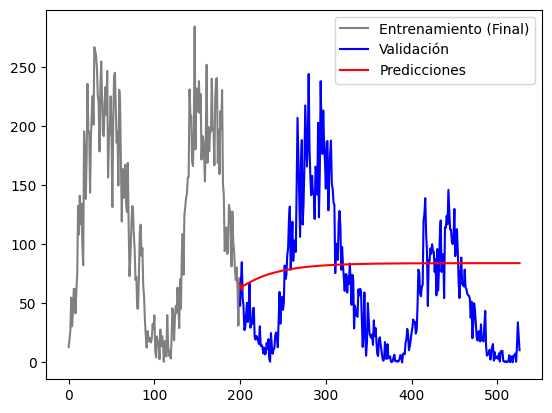

In [10]:
s1 = serie[-200:].values
x1 = np.arange(len(s1))
x2 = np.arange(len(val))+200
plt.plot(x1,s1, label='Entrenamiento (Final)', color='gray')
plt.plot( x2, val, label='Validación', color='blue')
plt.plot( x2, pronostico, label='Predicciones', color='red')
plt.legend()
plt.show()

###  Medición Matemática del Error de Pronóstico

La evaluación del desempeño predictivo de un modelo ARIMA se fundamenta en la cuantificación de las discrepancias entre los valores observados ($Y_{T+h}$) y las estimaciones puntuales generadas por el modelo ($\hat{Y}_{T+h|T}$) sobre un horizonte de tiempo $h$. Se define el **error de pronóstico** $e_{T+h}$ como:

$$e_{T+h} = Y_{T+h} - \hat{Y}_{T+h|T}$$

Para evaluar la precisión global del modelo sobre un conjunto de validación de tamaño $N$, se utilizan funcionales de pérdida que agregan estos errores individuales.

* **Raíz del Error Cuadrático Medio (RMSE):** Es la métrica estándar que penaliza de forma cuadrática las desviaciones grandes, siendo sensible a valores atípicos. Matemáticamente corresponde a la norma $L^2$ del vector de errores normalizada:
    
    $$RMSE = \sqrt{\frac{1}{N} \sum_{h=1}^{N} (Y_{T+h} - \hat{Y}_{T+h|T})^2}$$

* **Error Absoluto Medio (MAE):** Proporciona una medida lineal de la magnitud del error, siendo menos sensible a valores extremos que el RMSE. Corresponde a la norma $L^1$:
    
    $$MAE = \frac{1}{N} \sum_{h=1}^{N} |Y_{T+h} - \hat{Y}_{T+h|T}|$$



In [11]:
rmse = np.sqrt(mean_squared_error(val, pronostico))
mae = mean_absolute_error(val, pronostico)
print(f"Error  (RMSE): {rmse:.4f}")
print(f"Error  (MAE): {mae:.4f}")

Error  (RMSE): 59.5305
Error  (MAE): 51.4271


### Predición dinámica
La predicción dinámica es una estrategia de pronóstico iterativa donde el modelo actualiza su conjunto de información condicionante $(\mathcal{I}_t)$ incorporando los datos reales observados ("ground truth") a medida que ocurren, en lugar de alimentarse de sus propias estimaciones previas para calcular los pasos subsiguientes. A diferencia del enfoque recursivo estático —donde el error de predicción en $t+1$ se propaga y amplifica hacia $t+2$—, la predicción dinámica reinicia los rezagos autoregresivos con los valores verdaderos en cada paso temporal; esto previene la deriva del pronóstico y la acumulación de errores, permitiendo evaluar la capacidad de ajuste del modelo a corto plazo en un entorno de "ventanas rodantes" (rolling windows) o validación continua (walk-forward validation).

In [12]:
history = [x for x in serie]
predicciones_rolling = []

for i in range(len(val)):

    model = ARIMA(history, order=(3, 0, 0))
    model_fit = model.fit()


    output = model_fit.forecast()
    yhat = output[0]
    predicciones_rolling.append(yhat)

    obs = val.iloc[i]

    history.append(obs)

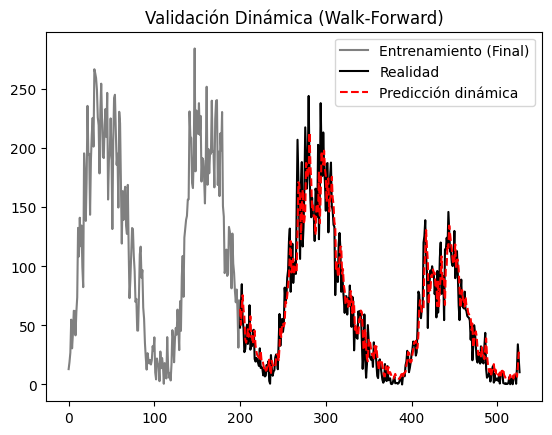

In [13]:

plt.plot( x1,s1, label='Entrenamiento (Final)', color='gray')

plt.plot( x2, val, label='Realidad', color='black')


plt.plot( x2, predicciones_rolling, label='Predicción dinámica', color='red', linestyle='--')

plt.title('Validación Dinámica (Walk-Forward)')
plt.legend()
plt.show()

In [14]:
rmse_dynamic = np.sqrt(mean_squared_error(val, predicciones_rolling))
mae_dynamic = mean_absolute_error(val, predicciones_rolling)
print(f"Error Dinámico (RMSE): {rmse_dynamic:.4f}")
print(f"Error Dinámico(MAE): {mae_dynamic:.4f}")

Error Dinámico (RMSE): 19.1792
Error Dinámico(MAE): 13.4841
